# Variations on HDBSCAN

A good way to think about gamma-linkage is that it is a generalization of the HDBSCAN clustering algorithm (CMS13). In this demo, we describe some of the variations on HDBSCAN one can obtain using gamma-linkage.

Note: in this demo, we'll use the implementation of HDBSCAN provided by the gamma-linkage code. For a high-performance implementation of gamma-linkage, see [hdbscan](<https://github.com/scikit-learn-contrib/hdbscan>).

In [1]:
import pandas as pd
from linkage.linkage import *

As a running example, we'll consider a sample from a mixture of Gaussians in the plane, with some added uniform noise.

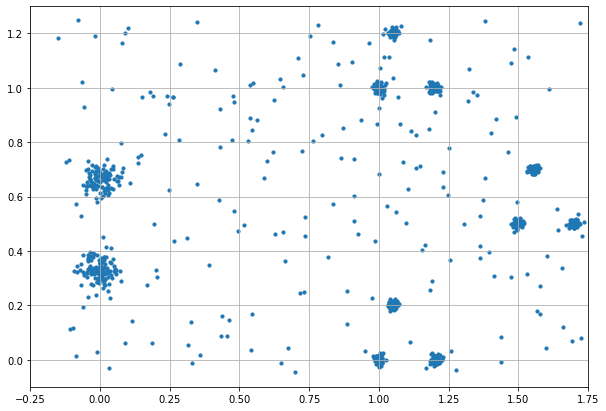

In [2]:
# Load the dataset and plot it using matplotlib

file_name = 'hdbscan_demo_files/multiscale_gaussians.txt'
data_as_pd = pd.read_csv(file_name, header=None)
data = np.asarray(data_as_pd)
n = data.shape[0] # number of data points

x_min = -0.25
x_max = 1.75
y_min = -0.1
y_max = 1.3
figsize_c = 5
figsize = (figsize_c * (x_max - x_min), figsize_c * (y_max - y_min))
dotsize = 10
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize)
plt.grid()
plt.show()

Roughly speaking, HDBSCAN works in two steps: construct a hierarchical clustering of the data (the hierarchical clustering is called *robust single-linkage*), then extract a single optimal clustering from the hierarchy.

The robust single-linkage depends on a density threshold *k*. To get an idea of how the hierarchical clustering changes with *k*, consider the following "vineyard" plot:

![](hdbscan_demo_files/multiscale_gaussians_vineyard_hdbscan_curves.png)

For each *k* we plot the total persistence of each point in the persistence diagram of the robust single-linkage w.r.t. *k*. 

The persistence diagram of a hierarchical clustering is a visualizable summary of the hierarchical clustering: each point of the persistence diagram corresponds to a leaf, and the total persistence of the point is a measure of the prominence of the leaf. For more details, see (RS20, Section 5).

(In the plot, we omit the most persistent point in the persistence diagram. This point is sometimes dramatically higher than all other points, which makes the plot harder to read. To see how to compute the vineyard plot, see the notebook example-2-clusters.)

We see many features have high prominence when *k* is in the range 20 -- 50, so we'll try HDBSCAN with *k* in this range.

The second step of HDBSCAN, extracting an optimal clustering, depends on a minimum cluster size *m*. If we don't know what to choose, we can first find all values of *m* where the result changes.

In the next cell, we choose a *k* and a range min_m < max_m for *m*. The output is a list of pairs \[(*m*, *q*)\], where *m* is a parameter choice where the output of HDBSCAN changes, and *q* is the number of clusters in the result.

In [3]:
# running HDBSCAN with a range of m

# choose parameters
absolute_k = 30
min_m = 2
max_m = 100

normalized_k = absolute_k / n
x = MPSpace(data)
x.fit(maxk = absolute_k)
hdbscan_gamma = Gamma_curve.constant_k_alpha_s_indexed(normalized_k) # gamma has constant k component
hdbscan_hc = x.gamma_linkage(hdbscan_gamma, consistent = True) # consistent=True indexes with 1/s
hdbscan_labels, critical_m = hdbscan_hc.measure_based_flattening_several_m(min_m, max_m)
print(critical_m)

[(2, 11), (53, 9), (61, 8), (67, 7), (73, 6), (74, 5)]


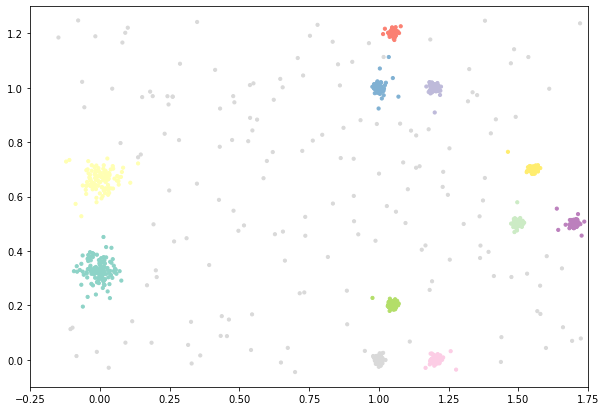

In [4]:
# choose m and plot the HDBSCAN clustering w.r.t k and m

m = 20
hdbscan_clustering = hdbscan_labels[m - min_m]

def grey_minus1(clustering): cl = clustering.copy() ; cl[cl == -1] = 7.5 ; return cl

# plot the clustering
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize, c=grey_minus1(hdbscan_clustering), cmap="Set3")
plt.show()

## What is Gamma-linkage?

Given an input metric space *X*, the robust single-linkage of *X* w.r.t. *k* is a one-parameter hierarchical clustering. If we consider all possible values of *k*, we get a two-parameter hierarchical clustering: this was observed by McInnes--Healy (MH18).

In (RS20), this multi-parameter hierarchical clustering is called *kernel linkage*. In fact, in that paper kernel linkage is a three-parameter hierarchical clustering, but we'll ignore that extra parameter in this demo.

In the following plot, we display a heat map illustrating this two-parameter object. At a point (*s*, *k*), the heat map indicates the proportion of points in our dataset that have appeared in the kernel linkage w.r.t. *s* and *k*. (The *k* values in this plot are normalized by the size of the dataset.)

The horizontal line indicates robust single-linkage for *k* = 50. The other line indicates another possible one-parameter hierarchical clustering. In general, we use "gamma" to refer to a curve through this parameter space, and *gamma-linkage* is the resulting one-parameter hierarchical clustering.

![](hdbscan_demo_files/multiscale_gaussians_shadow.png)

## First variation on HDBSCAN

The parameter *s*, which is the parameter over which the robust single-linkage varies, is a distance scale. To get a one-parameter family of lines through kernel linkage, a natural choice is to fix the *s*-intercept at the value at which the single-linkage clustering of the data becomes connected.

Then, choosing a *k*-intercept gives us a line through the kernel linkage parameter space. If we index the resulting one-parameter hierarchical clustering by 1 / *s*, like HDBSCAN, we get the following result on our running example:

![](hdbscan_demo_files/multiscale_gaussians_vineyard_one_over_s_indexed.png)

This plot is similar to the plot we saw with HDBSCAN, although now the curves we see are continous. There are many features with large prominence when *k* is in the range 30 - 70, so we will consider *k* in this range.

In [5]:
# running gamma-linkage

# choose parameters
s = x.connection_radius()
absolute_k = 50
min_m = 2
max_m = 100

normalized_k = absolute_k / n
x = MPSpace(data)
x.fit(maxk = absolute_k)
gamma = Gamma_curve.linear_interpolator_alpha_s_indexed(normalized_k, s)
consistent_hc = x.gamma_linkage(gamma, consistent = True)

consistent_labels, critical_m = consistent_hc.measure_based_flattening_several_m(min_m, max_m)
print(critical_m)

[(2, 13), (9, 12), (13, 11), (53, 9), (61, 8), (67, 7), (73, 6), (75, 5)]


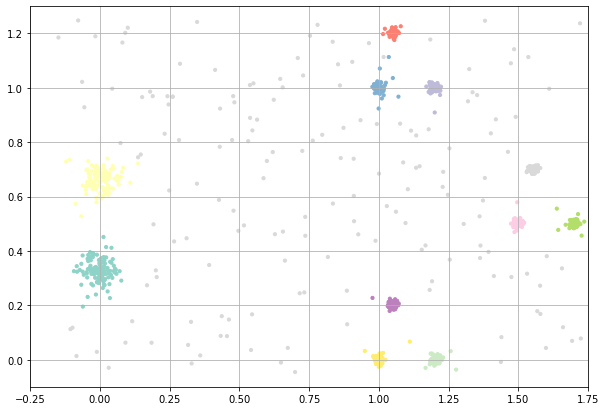

In [6]:
# choose m and plot the resulting flat clustering w.r.t k and m

m = 20
consistent_clustering = consistent_labels[m - min_m]

# plot the clustering
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize, c=grey_minus1(consistent_clustering), cmap="Set3")
plt.grid()
plt.show()

## Second variation on HDBSCAN

Another option is to use the same family of lines from the first variation, but to index by *k*, rather than 1 / *s*. This re-indexing makes a significant difference, as we see in the following plot.

![](hdbscan_demo_files/multiscale_gaussians_vineyard_k_indexed.png)

We see many features that have high prominence when *k* is in the range 30 -- 50. If we choose *k* in this range, we get a clustering that is similar to the ones we've already seen.

In [7]:
# running gamma-linkage

# choose parameters
s = x.connection_radius()
absolute_k = 40
min_m = 2
max_m = 100

normalized_k = absolute_k / n
x = MPSpace(data)
x.fit(maxk = absolute_k)
gamma = Gamma_curve.linear_interpolator_alpha_k_indexed(normalized_k, s)
k_index_hc = x.gamma_linkage(gamma, consistent = False)

k_index_labels, critical_m = k_index_hc.measure_based_flattening_several_m(min_m, max_m)
print(critical_m)

[(2, 14), (3, 13), (9, 12), (14, 11), (53, 9), (61, 8), (67, 7), (71, 6), (73, 5)]


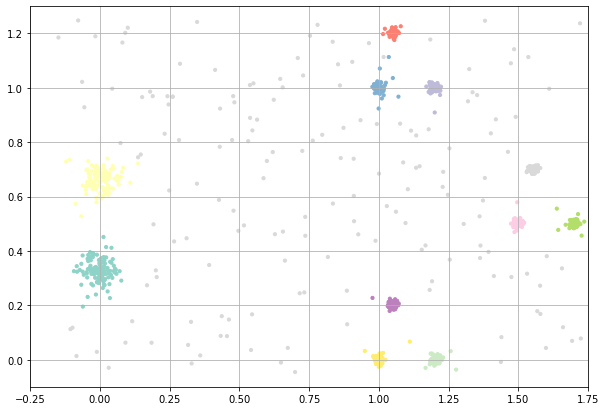

In [8]:
# choose m and plot the resulting flat clustering w.r.t k and m

m = 20
k_index_clustering = k_index_labels[m - min_m]

# plot the clustering
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize, c=grey_minus1(k_index_clustering), cmap="Set3")
plt.grid()
plt.show()

The vineyard plot also suggests there are prominent features for larger values of *k*. For example, when *k* is larger than 100, it looks like there are 5 "most prominent" clusters (recall that the most persistent point in the persistence diagram is always omitted).

If we try some *k* in this range, it turns out that the output is 4 clusters:

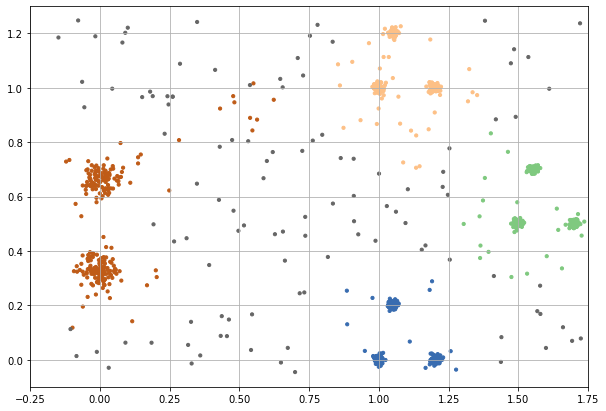

In [10]:
# running gamma-linkage

# choose parameters
s = x.connection_radius()
absolute_k = 100
m = 20

normalized_k = absolute_k / n
x = MPSpace(data)
x.fit(maxk = absolute_k)
gamma = Gamma_curve.linear_interpolator_alpha_k_indexed(normalized_k, s)
k_index_hc = x.gamma_linkage(gamma, consistent = False)
k_index_labels = k_index_hc.measure_based_flattening(m)

# plot the clustering
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize, c=-k_index_labels, cmap="Accent")
plt.grid()
plt.show()

## Third variation on HDBSCAN

Based on the vineyard plot from the previous variation, and looking at the data, it seems there should also be a clustering of this dataset with five clusters. How can we obtain this?

One option is to use the same hierarchical clustering from the last variation, but to change the way we extract an "optimal" clustering from the hierarchy. So, let's try the *persistence-based flattening*. This method first prunes the hierarchy according to persistence, then takes the flat clustering corresponding to the leaves of the pruned hierarchy. See (RS20, Section 5) for details.

Because this method involves taking leaves, the vineyard plot is especially helpful for this variation.

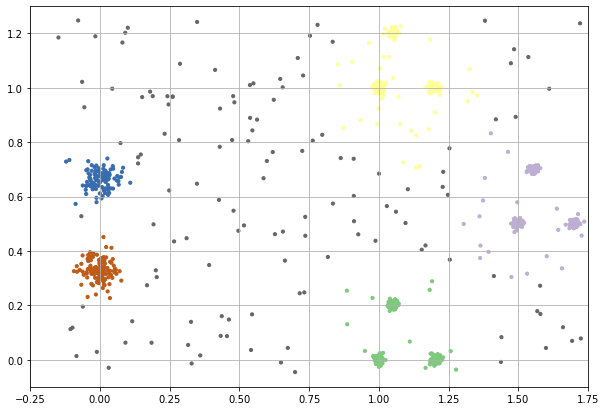

In [11]:
# running gamma-linkage + persistence-based flattening

# choose parameters
s = x.connection_radius()
absolute_k = 100
NUM_CLUSTERS = 5

normalized_k = absolute_k / n
x = MPSpace(data)
x.fit(maxk = absolute_k)
gamma = Gamma_curve.linear_interpolator_alpha_k_indexed(normalized_k, s)
k_index_hc = x.gamma_linkage(gamma, consistent = False)
persistence_labels = k_index_hc.persistence_based_flattening(num_clusters=NUM_CLUSTERS)[1]

# plot the clustering
plt.figure(figsize=figsize)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(data.T[0], data.T[1], s = dotsize, c=-persistence_labels, cmap="Accent")
plt.grid()
plt.show()

## References

(CMS13) R. Campello, D. Moulavi, and J. Sander. Density-based clustering based on hierarchical density estimates. In *Advances in Knowledge Discovery and Data Mining*, volume 7819 of *Lecture Notes in Computer Science*, pages 160–172. Springer, 2013.

(MH18) L. McInnes and J. Healy. Accelerated hierarchical density based clustering. In 2017 *IEEE International Conference on Data Mining Workshops (ICDMW)*, volume 00, pages 33–42, 2018.

(RS20) A. Rolle and L. Scoccola. Stable and consistent density-based clustering. arXiv:2005.09048v2, 2020.